# Language and words

  * State of the Union
  * Part of speech tagging
    * Linguistic dynamics of the SOTU
    * Linguistic complexity of the SOTU
  * Named entity recognition
    * Entity dynamics of the SOTU
  * Sentiment analysis
  * Word embeddings
  * Exercises
  * Appendixes
  
Previously, we explored some of the foundational techniques of natural language processing, focusing in particular on representing documents and texts as bags of words, and conducting some basic analyses. Although these techniques have proven to be extremely powerful, you probably noticed that the basic bag of words model throws away a lot of potentially really interesting and important linguistic information. In this session, we're going to take the linguistic nature of our textual data a bit more seriously. Specifically, we'll explore a number of techniques that help us not only better understand the structure of language but also help us get closer to the context and meaning of our texts.

# State of the Union

As usual, we'll organize our explorations around a specific example. This time, we'll focus on State of the Union Addresses. The complete set of addresses is made publicly available by the [American Presidency Project](https://www.presidency.ucsb.edu) at the University of California Santa Barbara, although not for direct download in a machine readable format. I wrote a simple web scraper to download the addresses, which you can find [here](download_sotu_data.py). Note that until the early 1900s, the president's [report to congress on the state of the union](https://www.presidency.ucsb.edu/documents/presidential-documents-archive-guidebook/annual-messages-congress-the-state-the-union) was typically delivered as a written letter, not a speech. For simplicity, we'll refer to them all as addresses, although we'll record a distinction between the two in the data. 

If you open up my State of the Union web scraper, you'll notice that the output is a `pandas` data frame, where each row is an address; columns include data on the title of the address, the url, president, delivery date, type, and of course, the raw text. Let's go ahead and load the data frame and check out the data.

In [66]:
# load some packages
import pandas as pd

In [67]:
# load data
sotu_df = pd.read_pickle("sotu_data/sotu_df.pickle")

# let's sort by date to help with our plotting later
sotu_df = sotu_df.sort_values("date")

# check out the data
sotu_df.head()

,title,url,president,date,text,type
237,First Annual Address to Congress,/documents/first-annual-address-congress-0,George Washington,1790-01-08,\nFellow-Citizens of the Senate and House of R...,address
236,Second Annual Address to Congress,/documents/second-annual-address-congress-0,George Washington,1790-12-08,\nFellow-Citizens of the Senate and House of R...,address
235,Third Annual Address to Congress,/documents/third-annual-address-congress-0,George Washington,1791-10-25,\nFellow-Citizens of the Senate and House of R...,address
234,Fourth Annual Address to Congress,/documents/fourth-annual-address-congress-0,George Washington,1792-11-06,\nFellow-Citizens of the Senate and House of R...,address
233,Fifth Annual Address to Congress,/documents/fifth-annual-address-congress,George Washington,1793-12-03,\nFellow-Citizens of the Senate and House of R...,address


Let's also take a quick look at how many records we have.

In [68]:
sotu_df.shape

(238, 6)

Seems reasonable. Without furtuer delay, then, let's get started with some natural language processing. 

# Part of speech tagging

Back in grammar school, you probably spent some diagramming sentences, and learning about nouns, verbs, adjectives, adverbs, prepositions, and so forth. You may still even think about these different parts of speech every now and then when writing. I know I have a bad tendency to use too many adjectives and adverbs, and I always make a point to cut out as many as I can when proof reading. Most likely, though, at least if you're like me, you probably haven't given too much serious thought to grammar since, well, grammar school.

Knowing something about the grammatical structure of a text can be really valuable for natural language processing, and we'll explore several reasons why throughout this notebook. Although there are several dimensions to grammatical structure, we can get pretty far even just considering the different parts of speech, which is what we'll focus on here. 

In natural language processing, identifying parts of speech to tokens in a given text is called part-of-speech tagging, or POS tagging, which most natural language processing packages will be able to do for you farily readily. There are several fairly widely used sets of POS tags, the most famous being the [Brown Corpus tagset](https://en.wikipedia.org/wiki/Brown_Corpus). We'll use what are known as the [Universal POS tags](https://universaldependencies.org/u/pos/), which are quite a bit simpler than the Brown tags, but will be fine for our purposes.

As in our previous session, we'll be using `spacy`. Let's get started!

In [69]:
# load some packages
import spacy
import datetime

# load spacy model
nlp = spacy.load("en_core_web_lg")

For now, let's focus on the 2020 State of the Union Address, given by President Donald Trump on February 4. 

In [70]:
# run nlp using spacy
sotu_2020_nlp = nlp(sotu_df[(sotu_df.president == "Donald J. Trump") 
                          & (sotu_df.date == datetime.date(2020, 2, 4))].text.iloc[0])

We'll narrow it down even further for now to focus just on the sixth sentence.

In [71]:
sotu_2020_nlp_sent6 = [sent for sent in sotu_2020_nlp.sents][5]

Now let's get the POS tags.

In [72]:
# get the pos tags and convert to pandas data frame for nice printing
pd.DataFrame([(token.text, token.pos_) for token in sotu_2020_nlp_sent6], columns = ["token", "pos_tag"])

,token,pos_tag
0,Three,NUM
1,years,NOUN
2,ago,ADV
3,",",PUNCT
4,we,PRON
5,launched,VERB
6,the,DET
7,great,ADJ
8,American,ADJ
9,comeback,NOUN


We did it! We could (and probably should) spend a lot more time digging into the details of what POS are, the algorithms used to identify them, and so forth. But the basic idea behind this notebook is to get you introduced to (and excited about) some of the different approaches available, so we'll skip those for now. Instead, let's try to scale up our POS tagging a little bit so we can conduct some basic analyses. Specifically, let's get some basic information on the distribution of POS tags for all the different SOTU addresses. We can do this pretty easily using a combination of `spacy` and `pandas`. We'll start out by creating a functon that will return a list of POS tags given a string of text (e.g., a SOTU address).

In [73]:
def get_pos_tags(text):
  """Given raw text, return a list of POS tags."""
  return [token.pos_ for token in nlp(text, disable=["ner","parser"])]

Now let's apply that function to our data frame.

In [74]:
sotu_df["pos_tags"] = sotu_df["text"].apply(get_pos_tags)

We're not necessarily interested in every POS tag. Let's get some counts of particular tags of interest.

In [75]:
# counts of nouns
sotu_df["nnouns"] = sotu_df["pos_tags"].apply(lambda x: x.count("NOUN"))

# counts of verbs
sotu_df["nverbs"] = sotu_df["pos_tags"].apply(lambda x: x.count("VERB"))

# counts of adjectives
sotu_df["nadjs"] = sotu_df["pos_tags"].apply(lambda x: x.count("ADJ"))

# counts of adverbs
sotu_df["nadvs"] = sotu_df["pos_tags"].apply(lambda x: x.count("ADV"))

# count of all nouns, verbs, adverbs, and adjectives (tags of "interest", or "i")
sotu_df["nitags"] = sotu_df["nnouns"] + sotu_df["nverbs"] + sotu_df["nadvs"] + sotu_df["nadjs"]

# count of all tokens
sotu_df["ntokens"] = sotu_df["pos_tags"].apply(len)

Let's also create some weighted versions of our POS measures, to help with plotting.

In [76]:
# proportion of nouns
sotu_df["pnouns"] = sotu_df["nnouns"]/sotu_df["nitags"]

# proportion of verbs
sotu_df["pverbs"] = sotu_df["nverbs"]/sotu_df["nitags"]

# proportion of adjectives
sotu_df["padjs"] = sotu_df["nadjs"]/sotu_df["nitags"]

# proportion of adverbs
sotu_df["padvs"] = sotu_df["nadvs"]/sotu_df["nitags"]

Finally, let's check out the results.

In [77]:
sotu_df.head()

,title,url,president,date,text,type,pos_tags,nnouns,nverbs,nadjs,nadvs,nitags,ntokens,pnouns,pverbs,padjs,padvs
237,First Annual Address to Congress,/documents/first-annual-address-congress-0,George Washington,1790-01-08,\nFellow-Citizens of the Senate and House of R...,address,"[SPACE, PROPN, PUNCT, PROPN, ADP, DET, PROPN, ...",227,137,108,34,506,1196,0.448617,0.270751,0.213439,0.067194
236,Second Annual Address to Congress,/documents/second-annual-address-congress-0,George Washington,1790-12-08,\nFellow-Citizens of the Senate and House of R...,address,"[SPACE, PROPN, PUNCT, PROPN, ADP, DET, PROPN, ...",277,167,135,55,634,1534,0.436909,0.263407,0.212934,0.086751
235,Third Annual Address to Congress,/documents/third-annual-address-congress-0,George Washington,1791-10-25,\nFellow-Citizens of the Senate and House of R...,address,"[SPACE, PROPN, PUNCT, PROPN, ADP, DET, PROPN, ...",469,275,206,100,1050,2528,0.446667,0.261905,0.196190,0.095238
234,Fourth Annual Address to Congress,/documents/fourth-annual-address-congress-0,George Washington,1792-11-06,\nFellow-Citizens of the Senate and House of R...,address,"[SPACE, PROPN, PUNCT, PROPN, ADP, DET, PROPN, ...",434,272,168,58,932,2319,0.465665,0.291845,0.180258,0.062232
233,Fifth Annual Address to Congress,/documents/fifth-annual-address-congress,George Washington,1793-12-03,\nFellow-Citizens of the Senate and House of R...,address,"[SPACE, PROPN, PUNCT, PROPN, ADP, DET, PROPN, ...",380,269,138,62,849,2149,0.447585,0.316843,0.162544,0.073027


## Linguistic dynamics of the SOTU

Let's see how different parts of speech have changed in the SOTU over time.

In [78]:
# load some packages
import matplotlib.pyplot as plt
import seaborn as sns

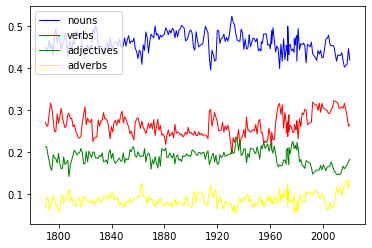

In [79]:
# create a plot of POS frequencies over time
plt.plot("date", "pnouns", data=sotu_df, marker="", color='blue', linewidth=1, label="nouns")
plt.plot("date", "pverbs", data=sotu_df, marker="", color='red', linewidth=1, label="verbs")
plt.plot("date", "padjs", data=sotu_df, marker="", color='green', linewidth=1, label="adjectives")
plt.plot("date", "padvs", data=sotu_df, marker="", color='yellow', linewidth=1, label="adverbs")
plt.legend()

Finally, let's see if we can notice any linguistic differences among presidents.

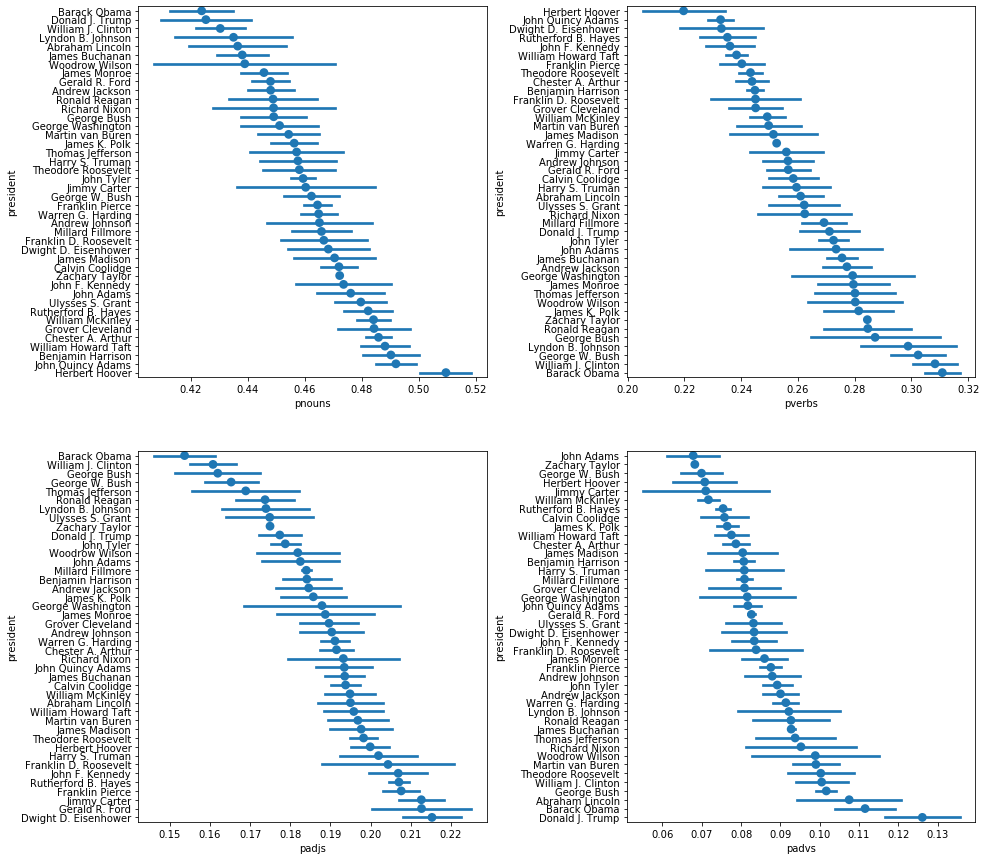

In [80]:
# plot
plt.figure(figsize=(15, 15))

# nouns
plt.subplot(2,2,1)
ax1 = sns.pointplot(x="pnouns", y="president", 
                    join=False, data=sotu_df.sort_values("pnouns"), 
                    order=sotu_df.groupby(["president"]).pnouns.mean().sort_values().index, 
                    ci="sd")

# verbs
plt.subplot(2,2,2)
ax2 = sns.pointplot(x="pverbs", y="president", 
                    join=False, data=sotu_df.sort_values("pverbs"), 
                    order=sotu_df.groupby(["president"]).pverbs.mean().sort_values().index, 
                    ci="sd")

# adjectives
plt.subplot(2,2,3)
ax3 = sns.pointplot(x="padjs", y="president", 
                    join=False, data=sotu_df.sort_values("padjs"), 
                    order=sotu_df.groupby(["president"]).padjs.mean().sort_values().index, 
                    ci="sd")

# adverbs
plt.subplot(2,2,4)
ax4 = sns.pointplot(x="padvs", y="president", 
                    join=False, data=sotu_df.sort_values("padvs"), 
                    order=sotu_df.groupby(["president"]).padvs.mean().sort_values().index, 
                    ci="sd")

# increase spacing between subplots
plt.subplots_adjust(wspace=0.4)

Looks like Donald Trump knows how to win __bigly__ at the adverbs game!

## Linguistic complexity of the SOTU

We can also use POS tags as a way of gaining some sense for the overall complexity of a piece of writing. As you might imagine, there are a whole lot of  ways we might think about characterizing the complexity of a text (see Lu et al., 2019 for a review). While the best approach will depend on your research objectives, [lexical density](https://en.wikipedia.org/wiki/Lexical_density) ($L_d$) is a nice, fairly general purpose measure. In brief, lexical density ($L_d$) is a measure of the number of content words (typically nouns, verbs, adjectives, and adverbs) relative to total words in a text. More formally, we can compute lexical density as 

$$LD = \frac{N_{\mathrm{l}}}{N}  \times  100,$$

where $N_{\mathrm{l}}$ is the total number of nouns, verbs, adjectives, and adverbs and N is the number of tokens in the text.

ALthough it doesn't use POS tags, as a basis of comparison, let's also compute another common measure of linguistic complexity, known as the type-token ratio (TTR). The type token ratio is simply the number of unique words relative to the total number of words in a text. We'll also multiply by 100 to maintain comparability with our measure of lexical density.

Let's compute lexical density for the SOTU addresses and make some comparisons across presidents. To compute the type-token ratio, we'll need to count the number of unique tokens, which we have yet to compute. So let's start out by defining a function to compute the TTR.

In [81]:
def get_ttr(text):
  """Given raw text, return the type-token ratio."""
  tokens = [token.text for token in nlp(text, disable=["ner","parser"])]
  return (len(set(tokens)) / len(tokens)) * 100

Now we can actually compute the measures.

In [82]:
# lexical density
sotu_df["ld"] = (sotu_df["nitags"]/sotu_df["ntokens"])*100

# type-token ratio
sotu_df["ttr"] = sotu_df["text"].apply(get_ttr)

Let's visualize our time series.

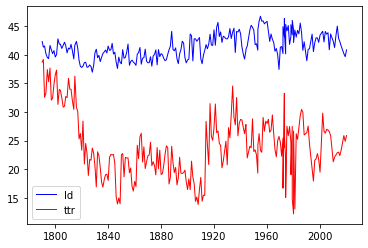

In [83]:
# create a plot of linguistic complexity measures over time
plt.plot("date", "ld", data=sotu_df, marker="", color='blue', linewidth=1, label="ld")
plt.plot("date", "ttr", data=sotu_df, marker="", color='red', linewidth=1, label="ttr")
plt.legend()

We can also make comparisons of presidents, as we did before.

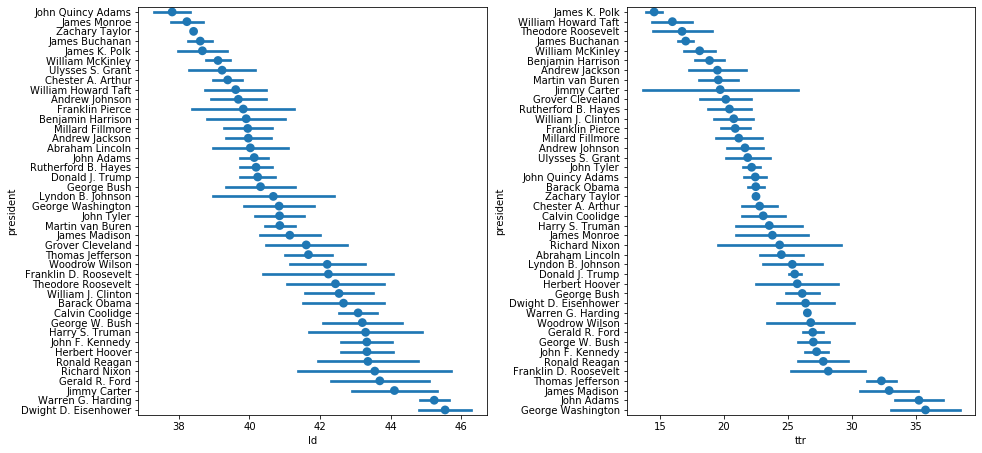

In [84]:
# plot
plt.figure(figsize=(15, 7.5))

# nouns
plt.subplot(1,2,1)
ax1 = sns.pointplot(x="ld", y="president", 
                    join=False, data=sotu_df.sort_values("ld"), 
                    order=sotu_df.groupby(["president"]).ld.mean().sort_values().index, 
                    ci="sd")

# verbs
plt.subplot(1,2,2)
ax2 = sns.pointplot(x="ttr", y="president", 
                    join=False, data=sotu_df.sort_values("ttr"), 
                    order=sotu_df.groupby(["president"]).ttr.mean().sort_values().index, 
                    ci="sd")

# increase spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Named entity recognition

Thus far, our focus on POS tags has been primarily motivated by substantive interest in what they can tell us about language. But POS tags can also be valuable as a tool for helping us to get other things we care about from texts. In particular, they are often helpful for extracting information from text, like named entities (e.g., people, organizations, places). For example, consider the POS tags in following sentence. 

In [154]:
sample_1 = nlp("""The University of Minnesota was founded in Minneapolis.""")

Which we can display nicely using the displacy tool in spacy.

In [156]:
spacy.displacy.render(sample_1, style="dep", options={"compact": True})

Notice that the name "The University of Minnesota" follows a particular POS tag pattern (i.e., DET, PROPN, ADP, PROPN) that we are also likely to see for other universities (e.g., "The University of Michigan"). So knowing these POS patterns might help us identify candidate entities for extraction within an unstructured text. (Of course, not all entity extraction techniques use POS tags.) While we're on the topic, let's explore how we can do named entity extraction in spacy. We'll start by adding to our prior sample sentence a bit.

In [91]:
sample_2 = nlp("""The University of Minnesota was founded in Minneapolis 
                  in 1851 as a college preparatory school, seven years 
                  prior to Minnesota's statehood.""")

In [ ]:
As with our POS tagging example above, we can get a sense for how spacy tags entities using the displacy tool.

In [ ]:
spacy.displacy.render(sample, style="ent")

Similar to our approach for POS tags, we'll write a little function that we can use to extract entities from our SOTU text.

In [92]:
def get_entities(text):
  """Given raw text, return a list entities."""
  return [(ent.text, ent.label_) for ent in nlp(text, disable=["parser"]).ents]

Now let's apply that function to our data frame.

In [93]:
sotu_df["entities"] = sotu_df["text"].apply(get_entities)

Let's check out the results.

In [95]:
sotu_df["entities"].head()

237    [(Senate, ORG), (House of Representatives, ORG...
236    [(Senate, ORG), (House of Representatives, ORG...
235    [(Senate, ORG), (House of Representatives, ORG...
234    [(Senate, ORG), (House of Representatives, ORG...
233    [(Senate, ORG), (House of Representatives, ORG...
Name: entities, dtype: object

As with our POS tagging exercise, we're not necessarily interested in all the different entities (and spacy reports quite a few). Let's get some counts of particular entities of interest. We'll also create some normalized versions.

In [96]:
# PERSON (people, including fictional)
sotu_df["nperson"] = sotu_df["entities"].apply(lambda x: [i[1] for i in x].count("PERSON"))
sotu_df["pperson"] = sotu_df["nperson"]/sotu_df["ntokens"]

# NORP (nationalities or religious or political groups)
sotu_df["nnorp"] = sotu_df["entities"].apply(lambda x: [i[1] for i in x].count("NORP"))
sotu_df["pnorp"] = sotu_df["nnorp"]/sotu_df["ntokens"]

# counts of ORG (companies, agencies, institutions, etc.)
sotu_df["norg"] = sotu_df["entities"].apply(lambda x: [i[1] for i in x].count("ORG"))
sotu_df["porg"] = sotu_df["norg"]/sotu_df["ntokens"]

# counts of GPE (countries, cities, states)
sotu_df["ngpe"] = sotu_df["entities"].apply(lambda x: [i[1] for i in x].count("GPE"))
sotu_df["pgpe"] = sotu_df["ngpe"]/sotu_df["ntokens"]

# counts of MONEY (monetary values, including unit)
sotu_df["nmoney"] = sotu_df["entities"].apply(lambda x: [i[1] for i in x].count("MONEY"))
sotu_df["pmoney"] = sotu_df["nmoney"]/sotu_df["ntokens"]

# counts of DATE (absolute or relative dates or periods)
sotu_df["ndate"] = sotu_df["entities"].apply(lambda x: [i[1] for i in x].count("DATE"))
sotu_df["pdate"] = sotu_df["ndate"]/sotu_df["ntokens"]

# counts of LAW (named documents made into laws)
sotu_df["nlaw"] = sotu_df["entities"].apply(lambda x: [i[1] for i in x].count("LAW"))
sotu_df["plaw"] = sotu_df["nlaw"]/sotu_df["ntokens"]

# counts of EVENT (named hurricanes, battles, wars, sports events, etc.)
sotu_df["nevent"] = sotu_df["entities"].apply(lambda x: [i[1] for i in x].count("EVENT"))
sotu_df["pevent"] = sotu_df["nevent"]/sotu_df["ntokens"]

Finally, let's check out some of the results.

In [99]:
sotu_df[["nperson", "pperson",
         "nnorp", "pnorp",
         "norg", "porg", 
         "ngpe", "pgpe", 
         "nmoney", "pmoney",
         "ndate", "pdate",
         "nlaw", "plaw",
         "nevent","pevent"]].head()

,nperson,pperson,nnorp,pnorp,norg,porg,ngpe,pgpe,nmoney,pmoney,ndate,pdate,nlaw,plaw,nevent,pevent
237,0,0.000000,1,0.000836,6,0.005017,6,0.005017,0,0.000000,0,0.000000,1,0.000836,0,0.0
236,1,0.000652,2,0.001304,14,0.009126,8,0.005215,0,0.000000,2,0.001304,0,0.000000,0,0.0
235,0,0.000000,6,0.002373,11,0.004351,22,0.008703,0,0.000000,3,0.001187,2,0.000791,0,0.0
234,0,0.000000,4,0.001725,17,0.007331,9,0.003881,0,0.000000,7,0.003019,1,0.000431,0,0.0
233,1,0.000465,4,0.001861,16,0.007445,25,0.011633,1,0.000465,5,0.002327,0,0.000000,0,0.0


## Entity dynamics of the SOTU

Let's examine whether and how the representation of different kinds of entities has changed over time in the SOTU.

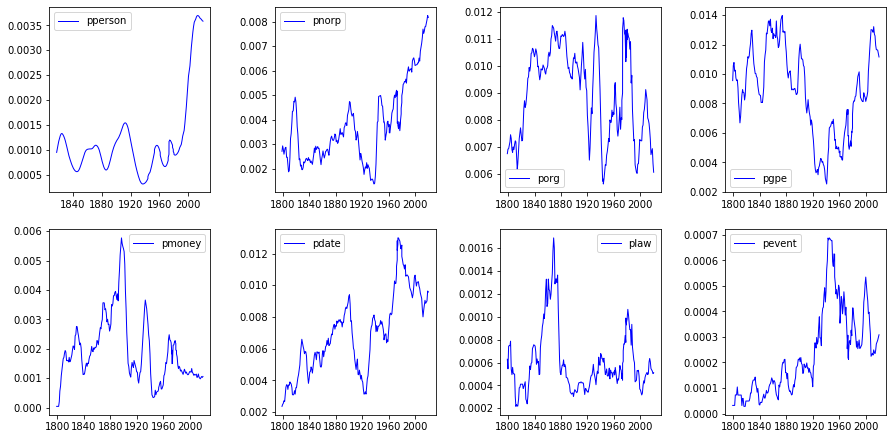

In [121]:
# create a plot of entity frequencies over time
plt.figure(figsize=(15, 7.5))

# loop over entities and plot
for i, entity in enumerate(["pperson", "pnorp", "porg", "pgpe", "pmoney", "pdate", "plaw", "pevent"]):
  
  # smoothing
  smoothed_df = sotu_df[[entity, "date"]].rolling(window=10, on="date").mean() 

  # add plot
  plt.subplot(2,4,i+1)
  plt.plot("date", entity, data=smoothed_df, marker="", color='blue', linewidth=1, label=entity)
    
  # add legend
  plt.legend()

# increase spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Sentiment analysis

Ostensibly, the SOTU is about the president communicating objective information to congress and the American people. But of course, the SOTU is also much more than that; it's also an emotional message, aimed at touting the president's accomplishments over the prior year, recognizing the stuggles and aspirations of citizens, and creating hope for the future. Surely we're missing something important about the SOTU (and many other texts of interest to social scientists) if we overlook this emotional character.

Within natural language processing, sentiment analysis is a set of tools and techniques for understanding the emotional character of texts. In a nutshell, the goal of most sentiment analysis techniques is to assign a score (or scores) to a given text that characterize its emotional valence (e.g., positivity, negativity). Although there are many different approaches to sentiment analysis (which is itself one of the most widely used applications of natural language processing), most techniques fall into one of two broad categories. 

  * __Dictionary approaches__ assign a valence to a text by looking at the relative occurrence of a predefined set of words, each of which has been assigned some valence (e.g., positive, negative). The appendix to this chapter includes a list of several popular dictionaries. 
  * __Machine learning approaches___ assign a valence to a text based on the occurrence of features observed in some training data. For example, many machine learning sentiment classifiers are trained on movie review data. Review scores (e.g., 0-10) are interpreted as corresponding to sentiment, and the classifier learns which words (or other linguistic features) are most closely associated with more positive versus more negative reviews.

Before we dig in, keep in mind that sentiment analysis is a tricky problem. As just one example, consider the following sentence (not my own, but unfortunately I can't track down the original author).

> Read the book.

Without context, this seems like a fairly neutral statement from an emotional point of view. That might change, of course, if this were a book review, in which case we might think of this sentence as having a fairly positive valence. But what if we saw the __exact__ same sentence in a movie review? There we might think of it as having a fairly negative valence (as in, skip the movie).

Let's apply sentiment analysis to the SOTU addresses. Turns out `spacy` does not have sentiment analysis capabilities built in, so we'll need to use a different library, called `TextBlob`. Like spacy, TextBlob is a general purpose natural language processing library. With respect to sentiment analysis, it offers both dictionary (based on the `pattern` library) and machine learning (based on movie reviews) based appraoches. Let's give them both a try!

In [194]:
# load some packages
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.sentiments import PatternAnalyzer
from textblob import Blobber

# initialize the dictionary-based analyzer
TBSentimentD = Blobber(analyzer=PatternAnalyzer())

# initialize the machine-learning-based analyzer
TBSentimentML = Blobber(analyzer=NaiveBayesAnalyzer())

We'll create a function to help us with the computations.

In [208]:
def get_sentiment(text, dictionary=False):
  """Given raw text, return several sentiment measures."""  
  if dictionary:
    polarity = TBSentimentD(text).sentiment.polarity
  else:
    polarity = TBSentimentML(text).sentiment
    polarity = polarity.p_pos - polarity.p_neg
  return polarity

In [209]:
# dictionary polarity
sotu_df["polarity_d"] = sotu_df["text"].apply(get_sentiment, dictionary=True)

In [210]:
# machine learning polarity
sotu_df["polarity_ml"] = sotu_df["text"].apply(get_sentiment, dictionary=False)

In [218]:
# let's check out the data
sotu_df[["polarity_d","polarity_ml"]].sample(10)

,polarity_d,polarity_ml
7,0.113117,1.0
207,0.116120,1.0
21,0.113510,1.0
154,0.143924,1.0
187,0.148201,1.0
...,...,...
150,0.129648,1.0
6,0.112068,1.0
148,0.155893,1.0
92,0.127008,1.0


Strangely, the machine learning approach seems to classify every speech as positive. Perhaps there is just too many differences between SOTU addresses and movie reviews for the training data to work very well. We can fiddle around a bit and see that this may be the case.

In [238]:
blob1 = TextBlob("This movie was just terrible.", analyzer=NaiveBayesAnalyzer())
blob1.sentiment

Sentiment(classification='pos', p_pos=0.5299636341194502, p_neg=0.4700363658805496)

In [ ]:
blob2 = TextBlob("This policy was just terrible.", analyzer=NaiveBayesAnalyzer())
blob2.sentiment

So we see that the sentiment changes quite a bit (for the positive) by changing just one word (movie to policy) that seems fairly uninformative to the emotional content of the text. For good measure, let's try the same quick exercise using the dictionary approach.

In [239]:
blob1 = TextBlob("This movie was just terrible.", analyzer=PatternAnalyzer())
blob1.sentiment

Sentiment(polarity=-1.0, subjectivity=1.0)

In [240]:
blob2 = TextBlob("This policy was just terrible.", analyzer=PatternAnalyzer())
blob2.sentiment

Sentiment(polarity=-1.0, subjectivity=1.0)

The results using the dictionary approach seem much more plausible. Note, however that you should not necessarily conclude that dictionary approaches are superior to machine learning techniques. Rather, the lesson is that you need to use the right tool given your data and other constraints. Dictionaries may be better when you do not have access to an existing machine learning classifier that's been trained on data similar enough to yours, nor the data or resources to build your own. By contrast, machine learning approaches will most likely work better when the training data are similar to those you wish to classify. Of course, you should also keep in mind that dictionaries may be made with particular contexts in mind (e.g., VADER for social media). 

Before we move on to our next topic, let's plot the results of our sentiment analyis. Since there's not much going on with the machine learning results, we'll just focus on our findings using the dictionary based method.

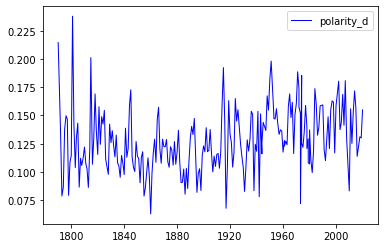

In [241]:
# create a plot of sentiment time
plt.plot("date", "polarity_d", data=sotu_df, marker="", color='blue', linewidth=1, label="polarity_d")
plt.legend()

Lastly, let's break it down by president.

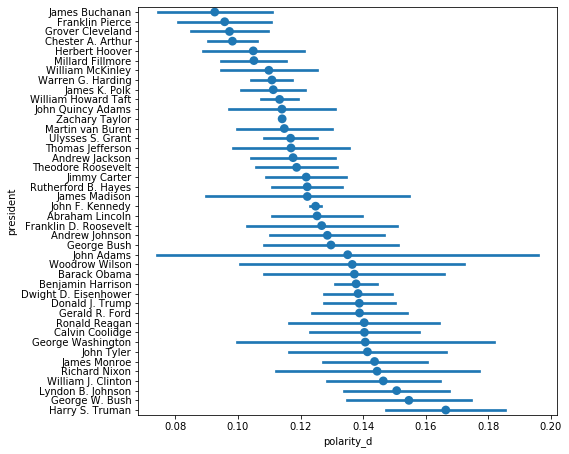

In [243]:
# plot
plt.figure(figsize=(7.5, 7.5))

# polarity_d
sns.pointplot(x="polarity_d", y="president", 
              join=False, data=sotu_df.sort_values("polarity_d"), 
              order=sotu_df.groupby(["president"]).polarity_d.mean().sort_values().index, 
              ci="sd")

# Word embeddings

One of the biggest ways that natural language processing has begun moving past the basic bag of words model is through advances in word embeddings. In brief, word embeddings position words in a high dimensional vector space, such that similar words appear closer and dissimilar words appear farther from one another in the space. As such, word embeddings allow us to get much closer to the meaning of a text than the clasic bag of words appraoch. As you might expect, spacy makes it pretty easy to work with word embeddings. There is a lot we can do with embeddings; we'll just cover the very basics to get you up and running here. 

To follow along, be sure to install one of the large word vector models from spacy, which you can do by uncommenting out the line of code below.

In [53]:
# %conda install -c conda-forge spacy-model-en_vectors_web_lg 

In [54]:
# load some packages
import spacy

In [55]:
# load embeddings model
nlp_embeddings = spacy.load("en_vectors_web_lg")

Let's see what an embedding looks like.

In [56]:
nlp_embeddings.vocab["computer"].vector

array([-0.26657  , -0.13717  ,  0.23549  , -0.26712  ,  0.093324 ,
        0.17563  , -0.33309  , -0.81744  ,  0.52655  ,  1.588    ,
        0.078138 , -0.093094 , -0.27167  , -0.31207  , -0.35018  ,
        0.072898 ,  0.032007 ,  2.5085   , -0.35727  , -0.018104 ,
        0.26102  , -0.3157   , -0.46466  ,  0.029905 ,  0.576    ,
       -0.34603  , -0.1502   , -0.23481  ,  0.20626  ,  0.28202  ,
       -0.6897   , -0.17632  ,  0.40369  ,  0.40672  ,  0.13068  ,
       -0.059988 , -0.3405   ,  0.46314  , -0.21149  ,  0.033152 ,
        0.36526  ,  0.049521 , -0.096128 , -0.087093 , -0.12957  ,
        0.22673  , -0.50435  , -0.50732  ,  0.27695  ,  0.14523  ,
       -0.11455  , -0.13968  ,  0.38549  ,  0.26088  , -0.43217  ,
       -0.45305  ,  0.072362 , -0.53383  ,  0.23317  ,  0.10471  ,
        0.51278  , -0.05899  ,  0.06051  ,  0.22083  ,  0.63098  ,
       -0.03232  , -0.36192  ,  0.45576  ,  0.037796 ,  0.21651  ,
        0.44988  , -0.33074  ,  0.32553  , -0.30153  , -0.2041

Now let's do a little exploration of some word vectors.

In [57]:
computer_vec = nlp_embeddings.vocab["computer"].vector
mouse_vec = nlp_embeddings.vocab["mouse"].vector
cat_vec = nlp_embeddings.vocab["cat"].vector
king_vec = nlp_embeddings.vocab["king"].vector
man_vec = nlp_embeddings.vocab["man"].vector
woman_vec = nlp_embeddings.vocab["woman"].vector

In [58]:
nlp_embeddings.vocab["cat"].similarity(nlp_embeddings.vocab["mouse"])

0.42720094

In [ ]:
nlp_embeddings.vocab["mouse"].similarity(nlp_embeddings.vocab["computer"])

In [ ]:
nlp_embeddings.vocab["cat"].similarity(nlp_embeddings.vocab["computer"])

One of the amazing things about word embeddings is that because our words are represented on vectors, we can do math on them. The results can be quite incredible. Let's write a function to help us with some explorations. Given a word vector (and a model) the function will return the most similar $n$ words. 

In [59]:
def get_most_similar(vector, model, n):
  """Given a vector, return most similar words based on embeddings from model."""
  similar = model.vocab.vectors.most_similar(np.array([vector]),n=n)
  return [model.vocab.strings[s] for s in similar[0][0]]

If you've read anything on word embeddings, you've probably see the example of $queen = king - man + woman$. Let's see if we can replicate that with some vector arithmetic. We'll start by looking at words similar to "king".

In [64]:
get_most_similar(vector=king_vec, model=nlp_embeddings, n=10)

['king',
 'KIng',
 'KING',
 'King',
 'kings',
 'KINGS',
 'Kings',
 'PRINCE',
 'prince',
 'Prince']

Now let's do $king - man + woman$.

In [65]:
queen = king_vec - man_vec + woman_vec
get_most_similar(vector=queen, model=nlp_embeddings, n=10)

['King',
 'king',
 'KING',
 'KIng',
 'queen',
 'Queen',
 'QUEEN',
 'prince',
 'Prince',
 'PRINCE']

Not bad!

As a final exercise, let's return to the SOTU. We'll use word embeddings to evaluate the similarity among presidents. To begin, let's create a new data frame that groups together all SOTUs by president.

In [129]:
president_df = sotu_df.groupby(["president"])["text"].apply(" ".join).reset_index()

# check out the result
president_df

,president,text
0,Abraham Lincoln,\nFellow-Citizens of the Senate and House of R...
1,Andrew Jackson,\nFellow Citizens of the Senate and of the Hou...
2,Andrew Johnson,\nFellow-Citizens of the Senate and House of R...
3,Barack Obama,"\nMadam Speaker, Vice President Biden, Members..."
4,Benjamin Harrison,\nTo the Senate and House of Representatives:\...
5,Calvin Coolidge,\nSince the close of the last Congress the Nat...
6,Chester A. Arthur,\nTo the Senate and House of Representatives o...
7,Donald J. Trump,"\nThe President. Mr. Speaker, Mr. Vice Preside..."
8,Dwight D. Eisenhower,"\nMr. President, Mr. Speaker, Members of the E..."
9,Franklin D. Roosevelt,"\nMr. President, Mr. Speaker, Senators and Rep..."


Now let's compute the pairwise similarities. We'll start out by running `nlp_embeddings` on the SOTU text for each president so that we have the embeddings.

In [140]:
president_df["text_nlp"] = president_df["text"].apply(nlp_embeddings)

Then we'll loop through and compute pairwise similarities among the presidents.

In [142]:
results = []
for president_1 in president_df.itertuples():
  results_president_1 = []
  for president_2 in president_df.itertuples():
    results_president_1.append(president_1[3].similarity(president_2[3]))
  results.append(results_president_1)

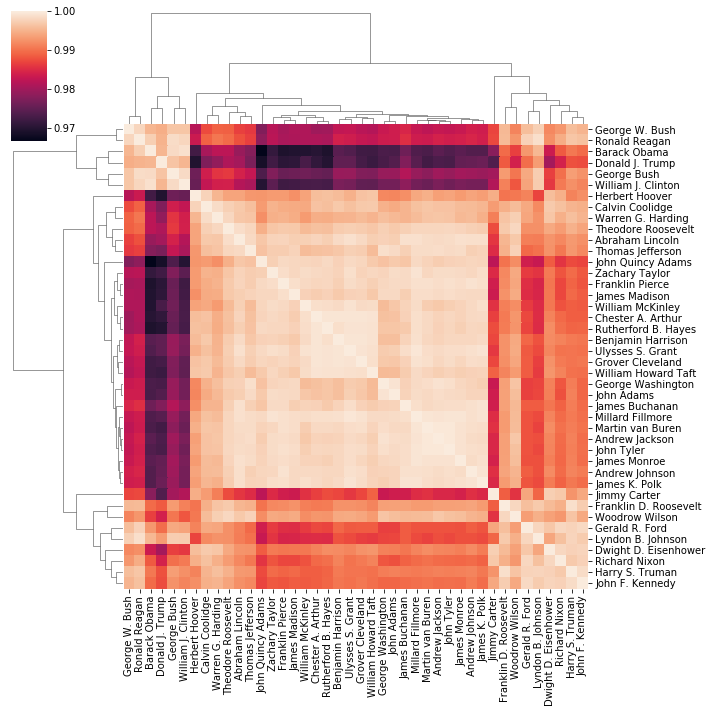

In [145]:
# convert our result to a numpy array
results = np.array(results)

# plot using seaborn
sns.clustermap(results, xticklabels=president_df.president, yticklabels=president_df.president)

These results are pretty amazing to me. They map reasonably well to the three periods identified in [prior work](https://www.pnas.org/content/112/35/10837) on the SOTU, which is impressive since I did absolutely no tuning or tweaking. What you see above is all I did. Overall, we see that the biggest differentiator is not so much political party, but rather era. There's a big group of early presidents who are all fairly similar (the big light box in the middle). Then there's a separate cluster for the mid 20th century presidents, followed by a smaller cluster for the modern era. 

# Exercises

  * Adapt the code from the entity recognition section above to determine the most referenced entities of each type in the SOTU address (i.e., not the most common entity forms, but rather the most common entities themselves, like "Russia" or "United Nations").
  * Write some code to develop a similarity matrix among presidents based on their SOTU addresses like the one above, but use vanilla tf-idf and cosine similarity, rather than word embeddings. How do the results compare?

# Appendixes

## Sentiment dictionaries
  * [Hu and Liu's Opinion Lexicon](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html#lexicon)
  * [Harvard General Inquirer](http://www.wjh.harvard.edu/~inquirer/homecat.htm)
  * [Multi Perspective Question Answering (MPQA) Project Subjectivity Lexicon](http://mpqa.cs.pitt.edu/lexicons/subj_lexicon/) | [Paper](http://people.cs.pitt.edu/~wiebe/pubs/papers/emnlp05polarity.pdf)
  * [Valence Aware Dictionary and sEntiment Reasoner (VADER) Lexicon](https://github.com/cjhutto/vaderSentiment) | [Paper](http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf)
  * [Stanford SocialSent](https://nlp.stanford.edu/projects/socialsent/)
  
Thanks to Michael Park and Ekaterina Levitskaya for helping to compile this list.

## Packages

The natural language processing sofware landscape is evolving quickly, and `spacy` is not the only game in town. Here are a few other useful and popular packages that are worth a look.

  * [spaCy](https://spacy.io/)
    * [textacy](https://chartbeat-labs.github.io/textacy/build/html/index.html)
  * [TextBlob](https://textblob.readthedocs.io/en/dev/)
  * [flair](https://github.com/flairNLP/flair)
  * [gensim](https://radimrehurek.com/gensim/)
  * [AllenNLP](https://allennlp.org/)
  * [polyglot](https://github.com/aboSamoor/polyglot)
  * [Pattern](https://www.clips.uantwerpen.be/pattern)
  * [Natural Language Toolkit](https://www.nltk.org/)
  * [Stanford CoreNLP](https://stanfordnlp.github.io/CoreNLP/)
  * [vaderSentiment](https://github.com/cjhutto/vaderSentiment)